In [1]:
'''
This script does an extraction of the energy spectrum from each pixel. 
It treates all of the pixels requested differently.
'''
%load_ext autoreload
%autoreload 2

In [2]:
import dataFile as df #class to open the data file
import matplotlib.pyplot as plt #plotting utility
import numpy as np 
from scipy import signal #used for convolutions
from scipy import optimize #used for fitting
import os #used for file operations
import pickle #used for saving temporary results

from multiprocessing import Lock, Process, Queue, current_process #to make things faster
import multiprocessing as mp

#advanced plotting routines
from pylab import rcParams
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from pylab import rcParams



In [3]:
#first define a bunch of commonly used functions
#this adjusts the waveform to have a 0 baseline and whatnot
def baselineShift(wave, window):
    #flip the waveform over
    wave = wave[:] * -1
    #now find the baseline and shift it to 0
    wave = wave[:] - np.mean(wave[:window])
    return wave    

def trapezoidalFilter(wave, rise, top, tau):
    #first define the filter
    filt = np.zeros(rise * 2 + top)
    for i in range(rise):
        filt[i] = i+tau
        filt[i+rise+top] = rise-tau-i
    for i in range(rise, rise+top):
        filt[i]=rise
    scale = 1.0/(rise * tau)
    filt = np.multiply(filt, scale)
    filterLength = rise * 2 + top
    #now apply the filter
    res = signal.fftconvolve(wave, filt, mode='same')
    return res

def findPeaks(wave):
    height = None
    threshold = None
    distance = 500
    prominence = 50
    width = 100
    wlen = None
    rel_height = 0.5
    plateau_size = None
    peaks, props = signal.find_peaks(wave, height = height, 
                                    threshold = threshold, distance = distance, 
                                    prominence = prominence, width = width,
                                    wlen = wlen, rel_height = rel_height,
                                    plateau_size = plateau_size)
    return peaks

def getFileNames(fileDir):
    dataFileNames = []
    if os.path.isdir(fileDir):  #if the given path is a directory, find all data files in that directory and analyze them
        tempFileNames = [f for f in os.listdir(fileDir) if os.path.isfile(os.path.join(fileDir, f))] #grab all files that are actually files, not directories
        tempFileNames = [fileDir + fileName for fileName in tempFileNames] #now add the path to the files onto each one
        #only grab the ones that are actually data files and have a .bin extension, otherwise ignore them
        for file in tempFileNames:
                name, extension = os.path.splitext(file)
                if extension == '.bin':
                    dataFileNames.append(file)
    elif os.path.isfile(fileDir): #if it is a file, assume they knew what they were doing and provided a real file  
        dataFileNames = [fileDir]
    dataFileNames.sort()
    return dataFileNames

#this function finds the energy from one peak in the waveform
def energyExtractionPeak(wave, peak, rise, top, threshold):
    #find the average value around the peak
    peakAverage = np.mean(wave[peak-10:peak+10])
    leftpoint = peak - rise - top*2
    if leftpoint < 0:
        leftpoint = 0
    baseline = np.mean(wave[leftpoint: leftpoint+50])
    return peakAverage - baseline

        

#this function finds the energy from multiple peaks by calling the above function
def energyExtractionWave(wave, peaks, rise, top, threshold):
    energies = []
    for peak in peaks:
        energy = energyExtractionPeak(wave, peak, rise, top, threshold)
        energies.append(energy)
    return energies

def perWaveAnalysis(wave):
    enerRise = 500
    enerTop = 100
    enerTau = 110
    enerThreshold = 0.8
    #do the baseline shift
    cleanwave = baselineShift(wave, 10000)
    #use this to identify the peaks we care about
    shortTrappedWave = trapezoidalFilter(cleanwave, 500, 1, 110)
    #now actually find the peaks
    peaks = findPeaks(shortTrappedWave)
    #use this for energy extraction
    #an approximate value for the decay rate is used here, can/should be updated
    longTrappedWave = trapezoidalFilter(cleanwave, enerRise, enerTop, enerTau) 
    energies = energyExtractionWave(longTrappedWave, peaks, enerRise, enerTop, enerThreshold)
    results = []
    for i in range(len(peaks)):
        results.append([peaks[i], energies[i]])
    return results 

In [4]:
#grab all of the files to be run over
files = getFileNames('/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44516-44785/')

In [5]:
pixelList = [i for i in range(16)]
energyTimingResults = [[] for pixel in pixelList]

if __name__ == '__main__':
    pool = mp.Pool(mp.cpu_count())
    for file in files:
        data = df.dataFile(file)
        print(file,files.index(file), len(files))
        for p in range(len(pixelList)):
            waves = data.getPixel(pixelList[p])
            results = pool.map(perWaveAnalysis, [wave for wave in waves])
            energyTimingResults[p].extend(results)


/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44516-44785/run44516.bin 0 270
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44516-44785/run44517.bin 1 270
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44516-44785/run44518.bin 2 270
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44516-44785/run44519.bin 3 270
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44516-44785/run44520.bin 4 270
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44516-44785/run44521.bin 5 270
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44516-44785/run44522.bin 6 270
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44516-44785/run44523.bin 7 270
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44516-44785/run44524.bin 8 270
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44516-44785/run44525.bin 9 270
/home/daqpearl/raidStorage/raidStorage/NDTGamma/Dec2019/run44516-44785/run44526.bin 10 270


Process ForkPoolWorker-26:
Process ForkPoolWorker-25:
Process ForkPoolWorker-17:
Process ForkPoolWorker-24:
Process ForkPoolWorker-32:
Process ForkPoolWorker-30:
Process ForkPoolWorker-23:
Process ForkPoolWorker-21:
Process ForkPoolWorker-16:
Process ForkPoolWorker-29:
Process ForkPoolWorker-31:
Process ForkPoolWorker-20:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-19:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Process ForkPoolWorker-10:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-22:
Traceback (most recent call last):
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-5:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/daqpearl/anaconda3/lib/python3.7/multiprocessing/process.py", line

KeyboardInterrupt: 

In [ ]:
energyTimingResultsFile = open('energyResultsSmallTest.pkl', 'wb')
pickle.dump(energyTimingResults, energyTimingResultsFile)

In [6]:
energyTimingResultsFile = open('energyResults.pkl', 'rb')
energyTimingResults = pickle.load(energyTimingResultsFile)

In [8]:
len(energyTimingResults[0])

3000

/home/daqpearl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/daqpearl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/daqpearl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/daqpearl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are reta

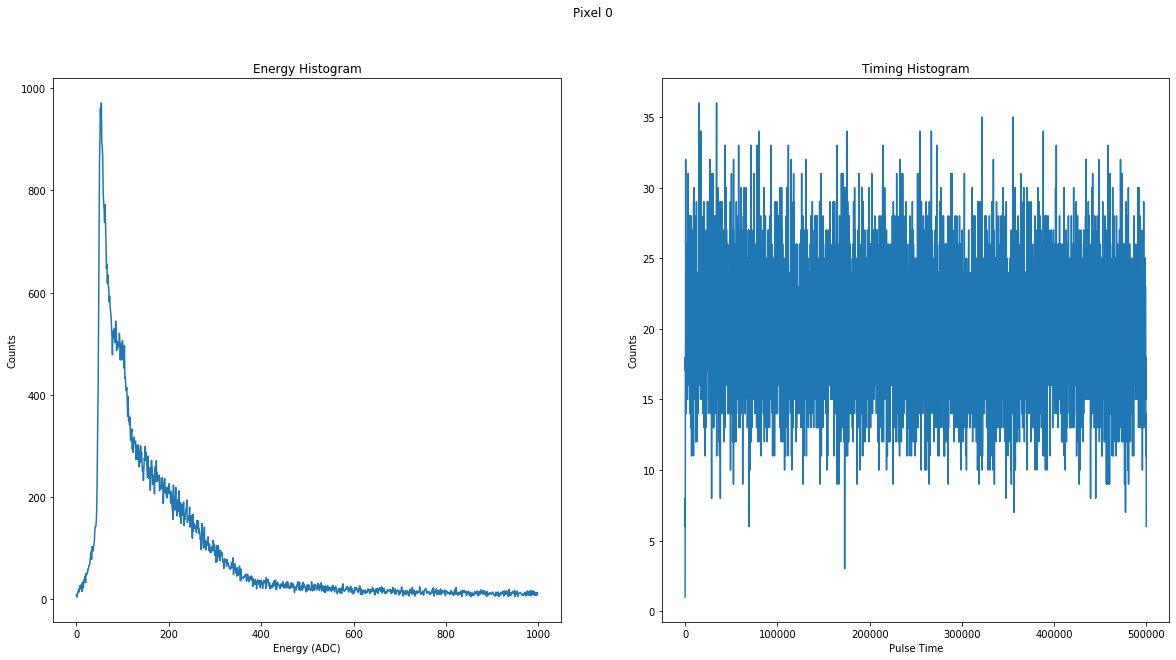

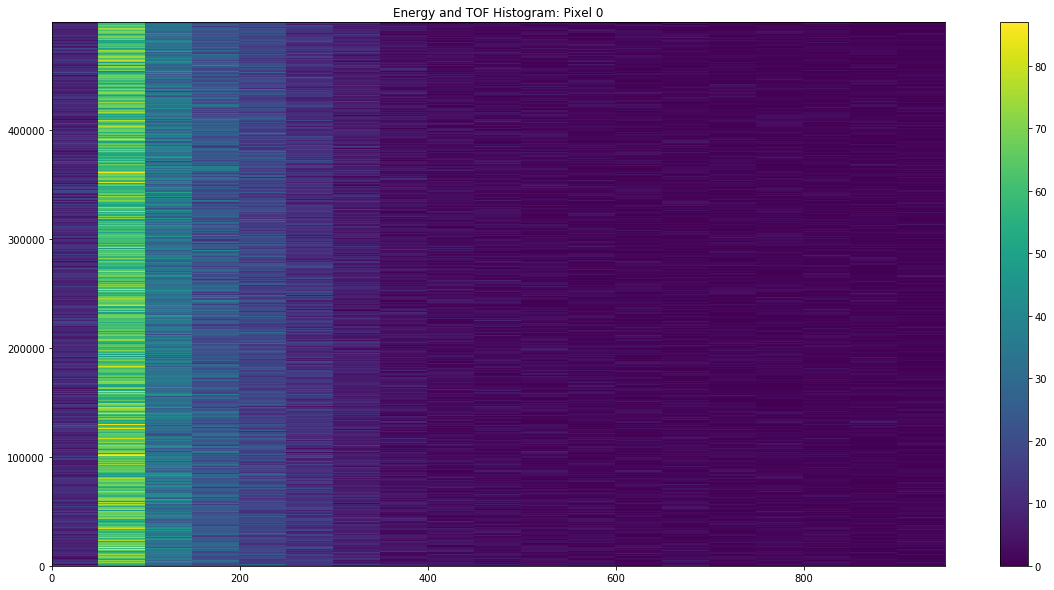

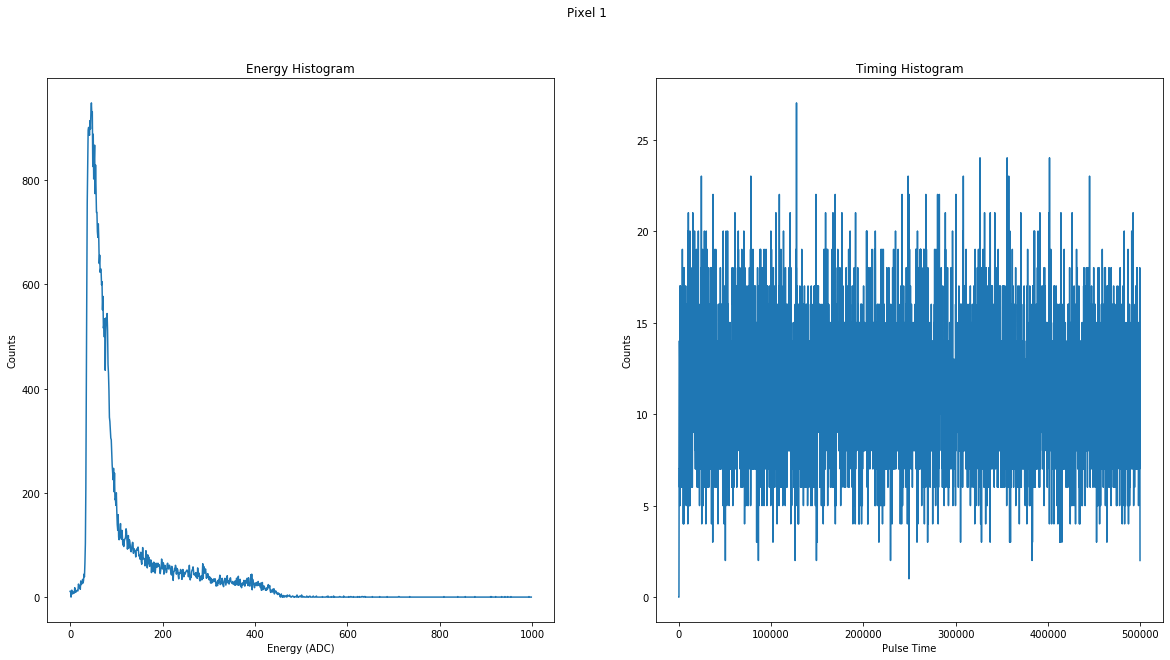

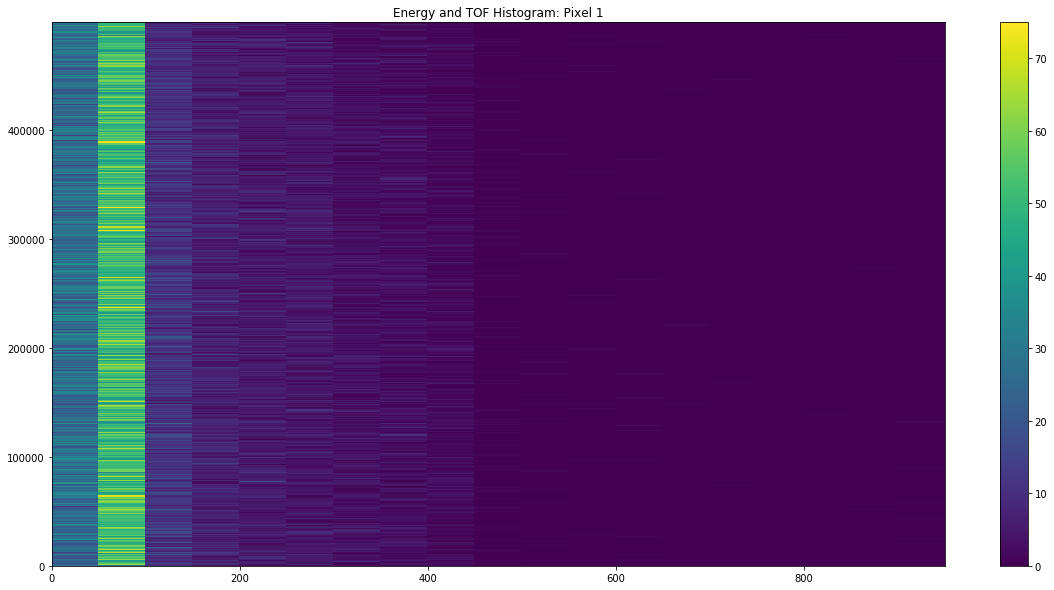

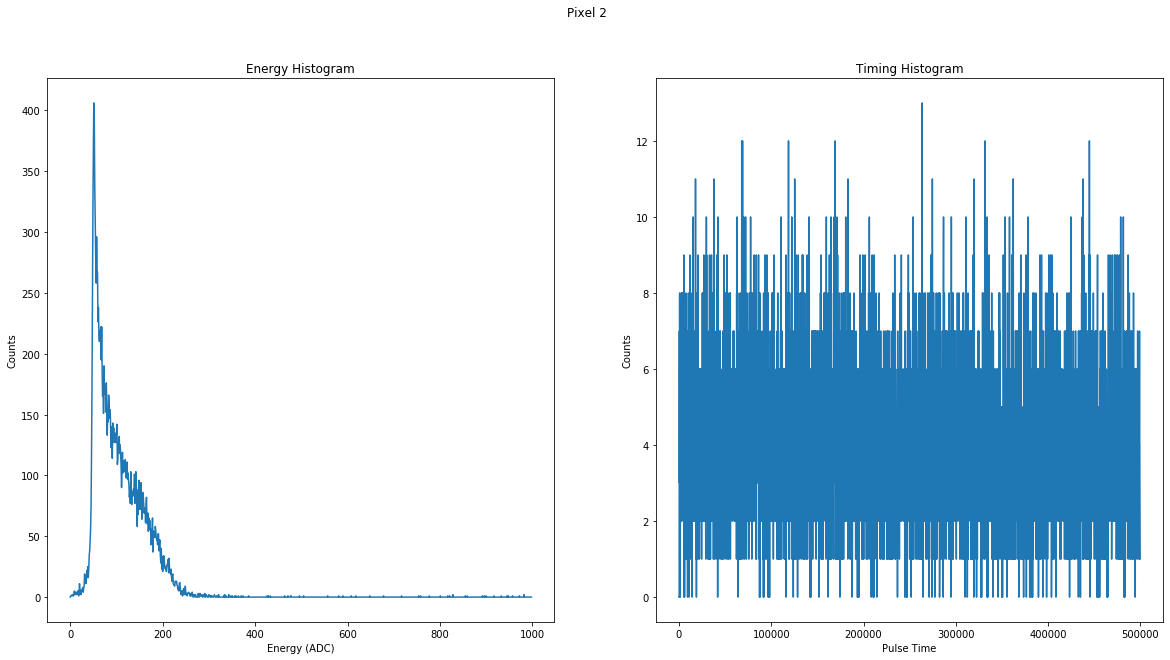

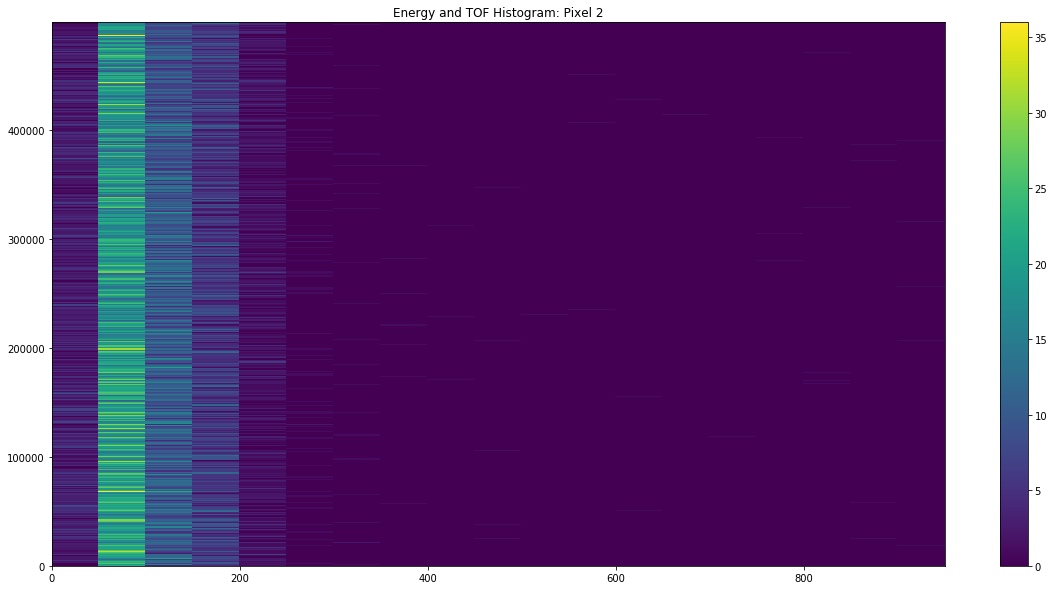

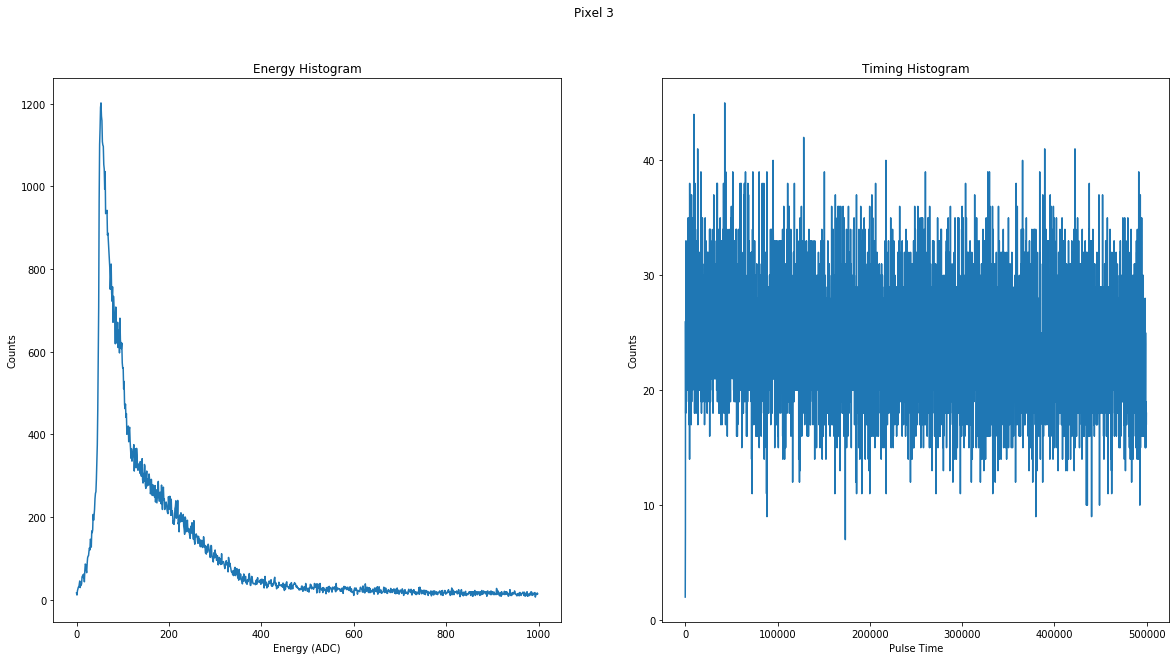

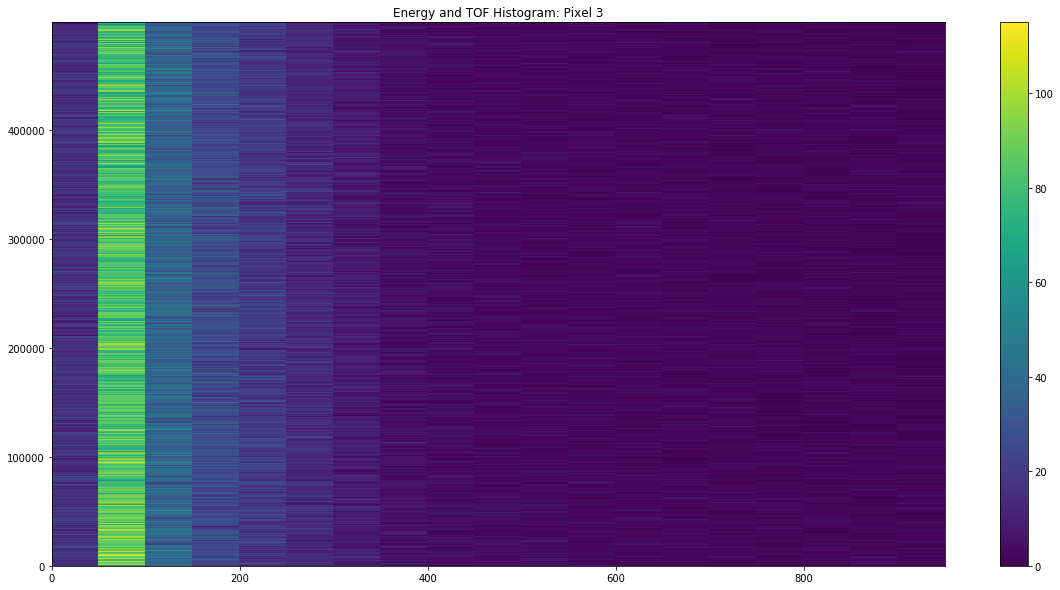

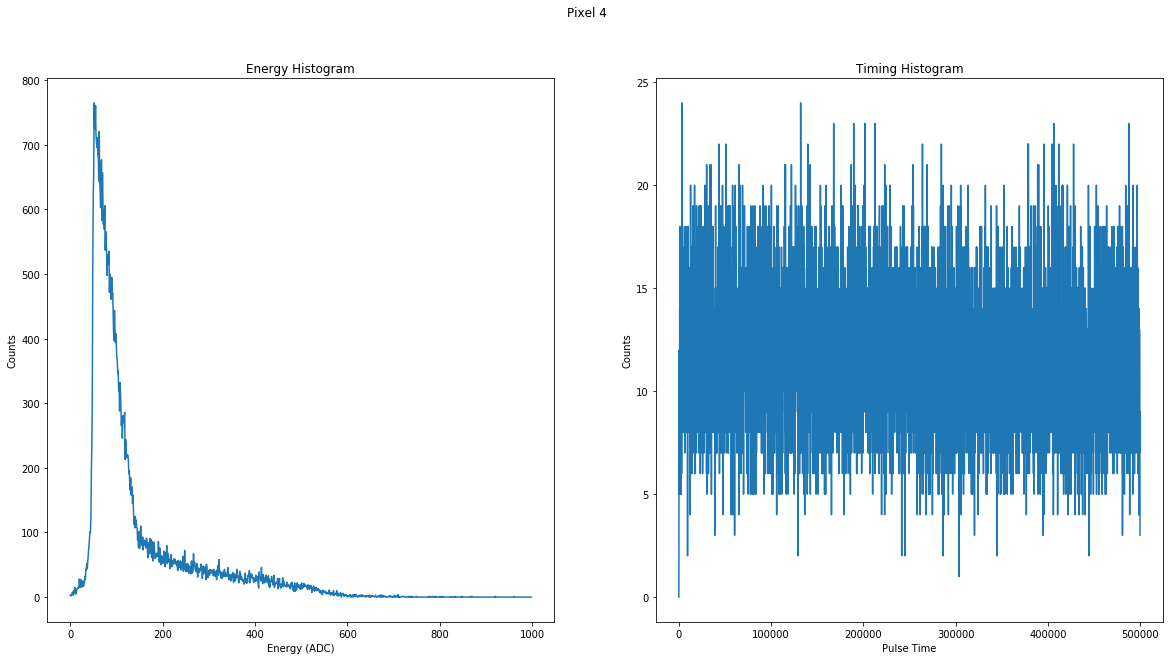

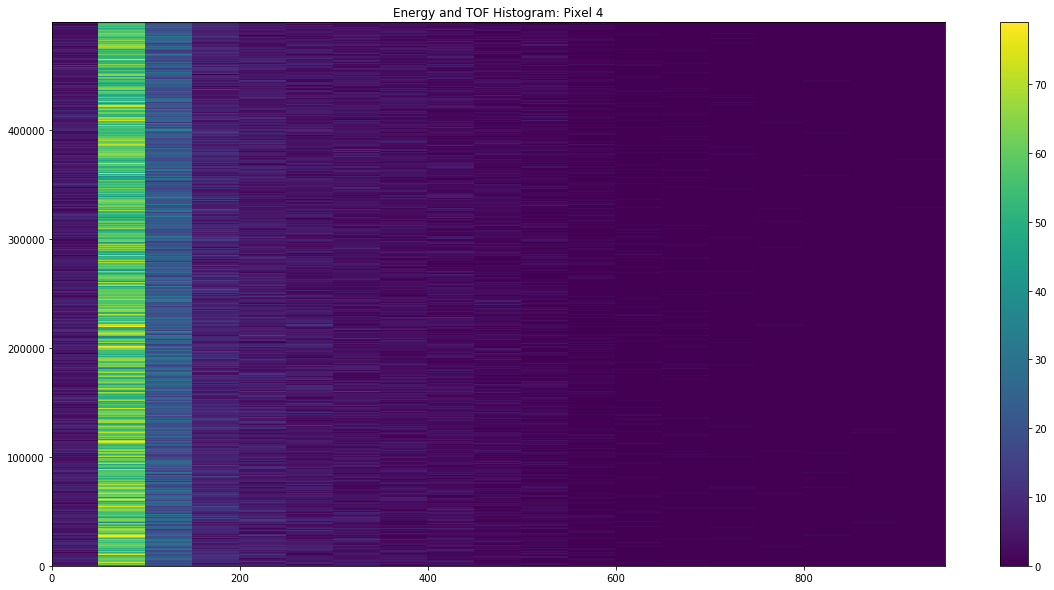

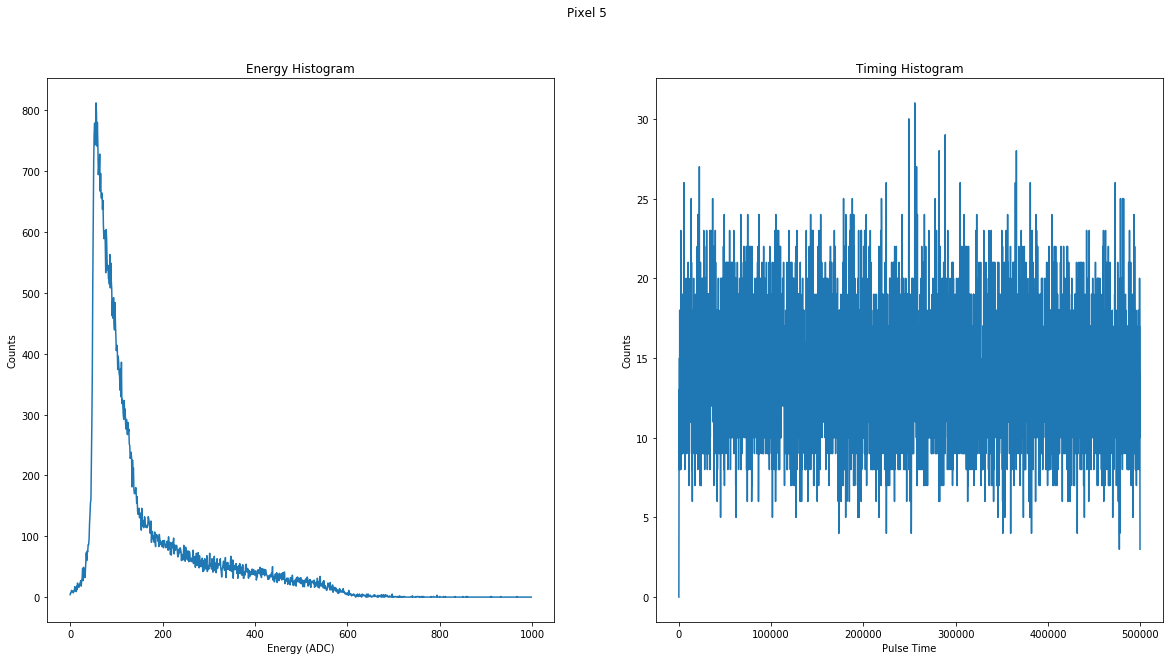

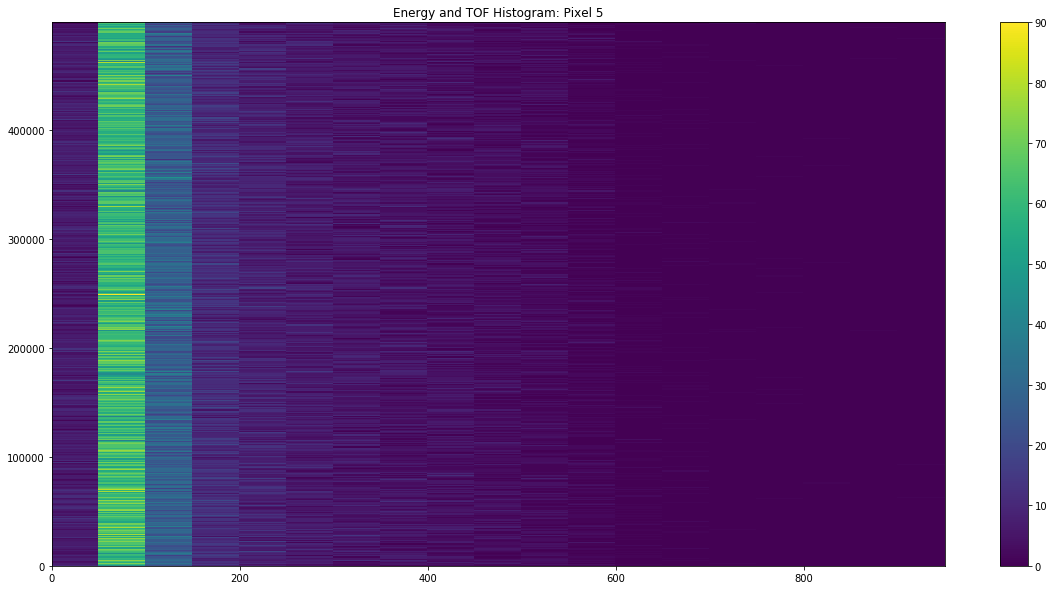

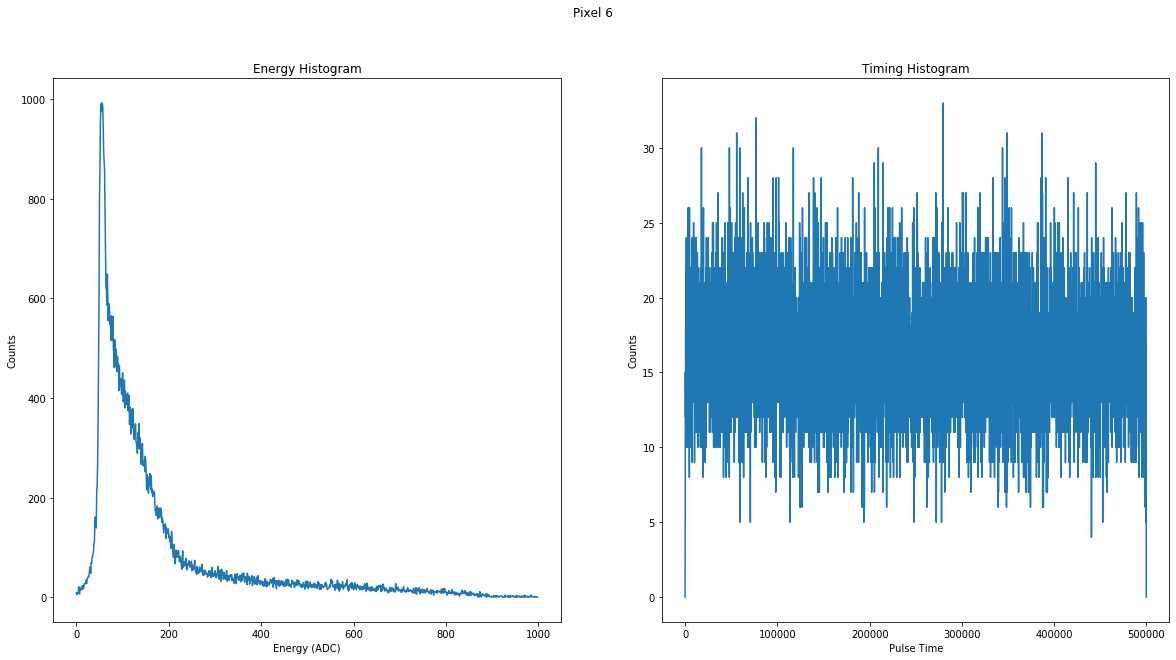

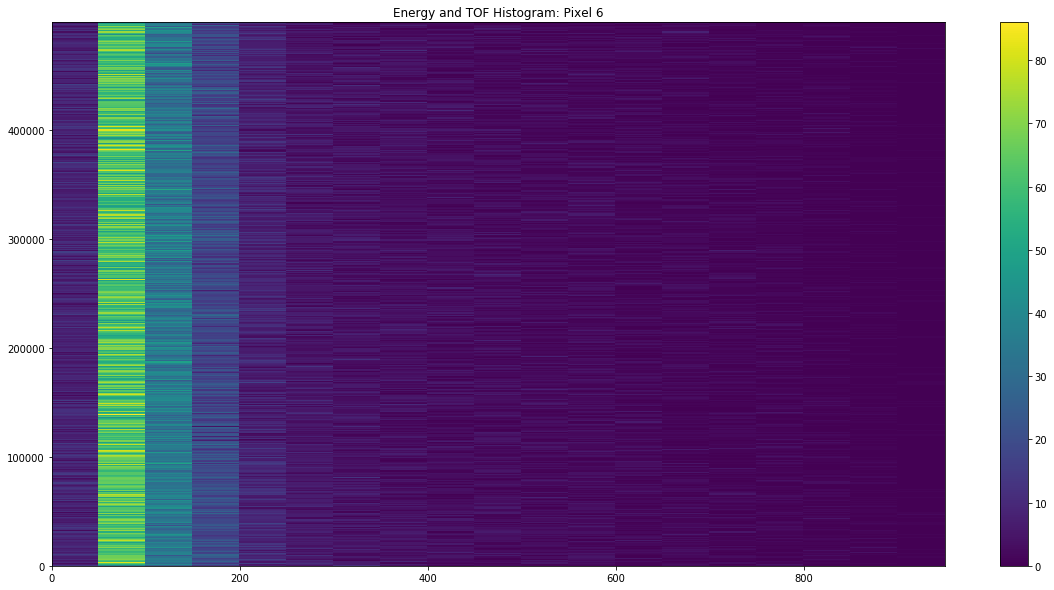

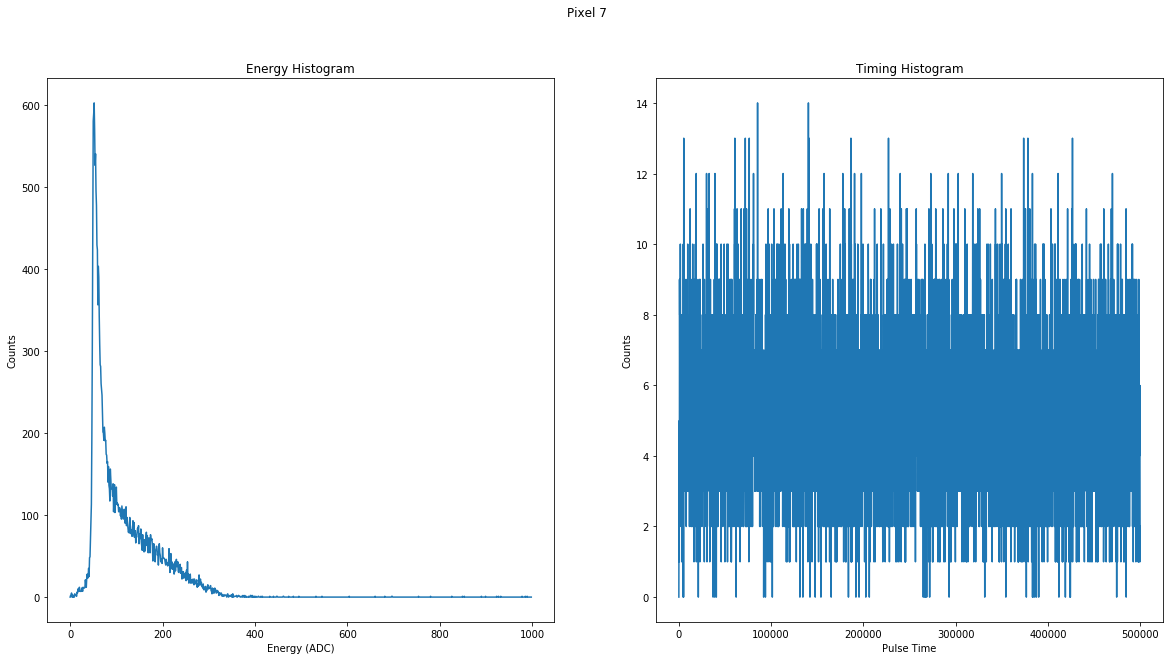

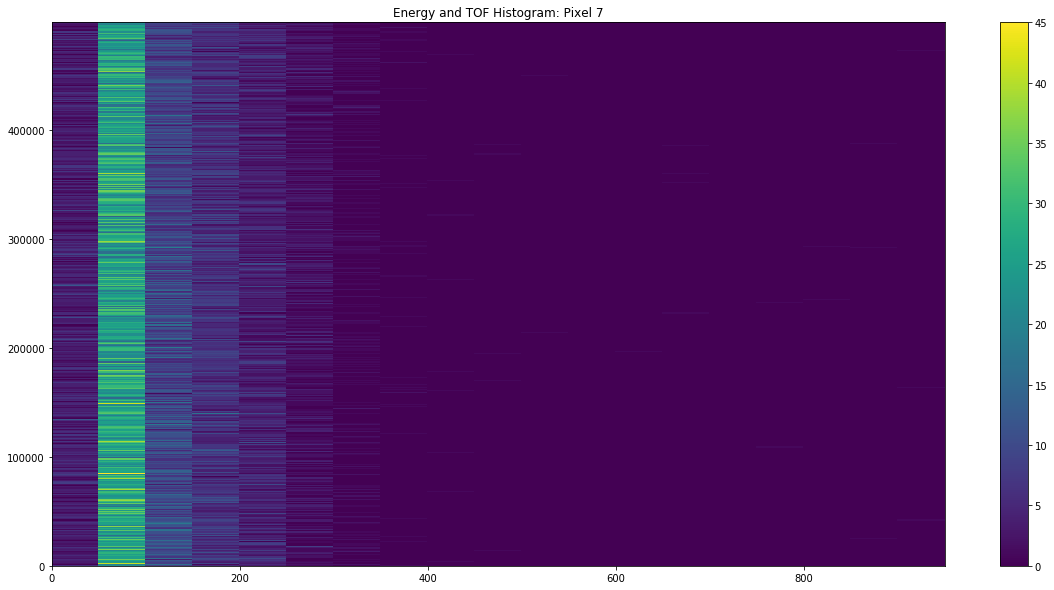

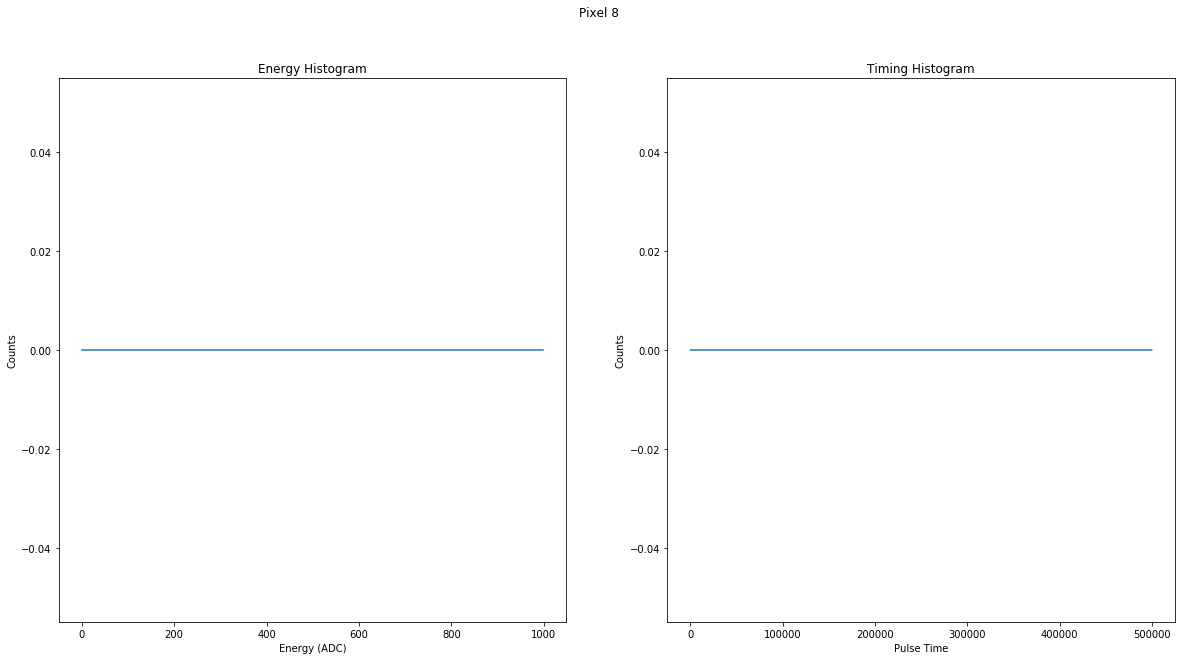

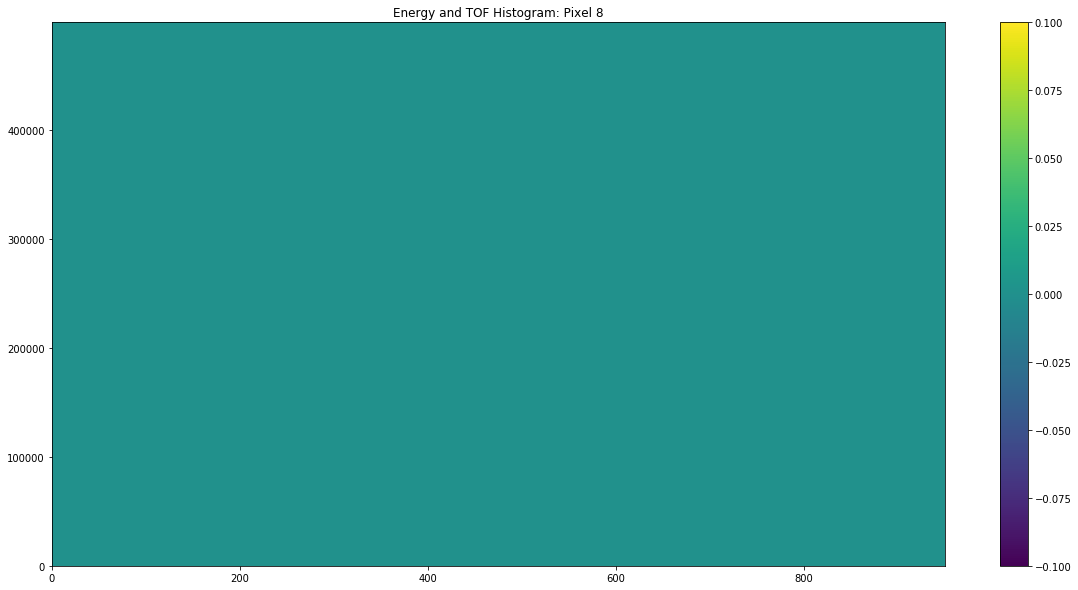

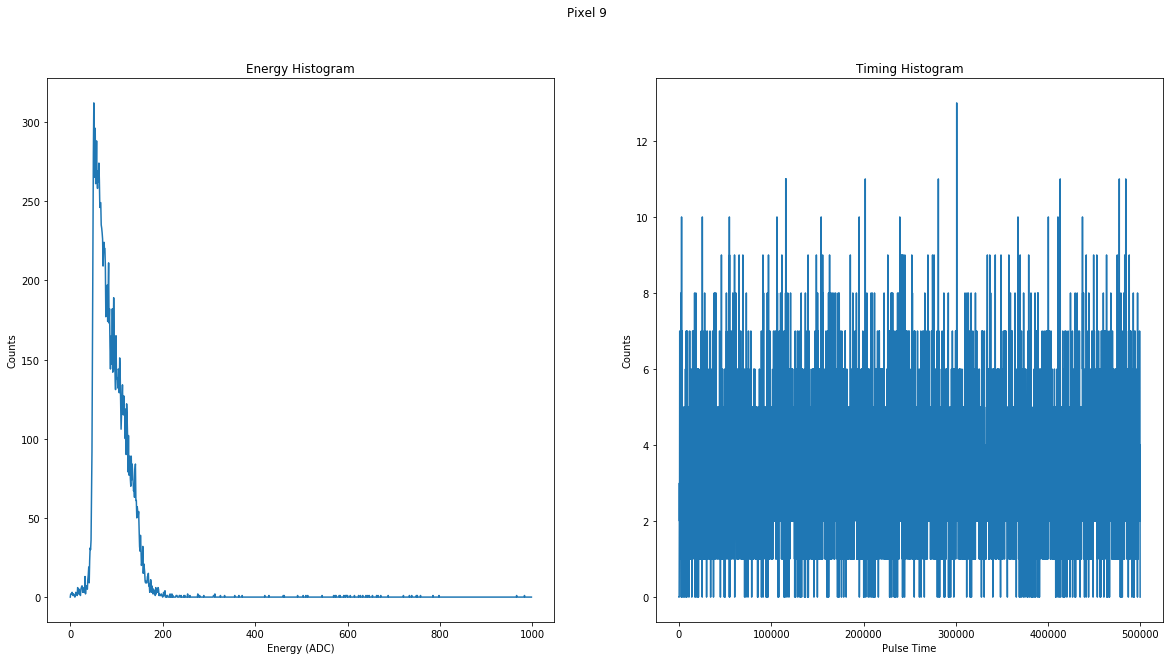

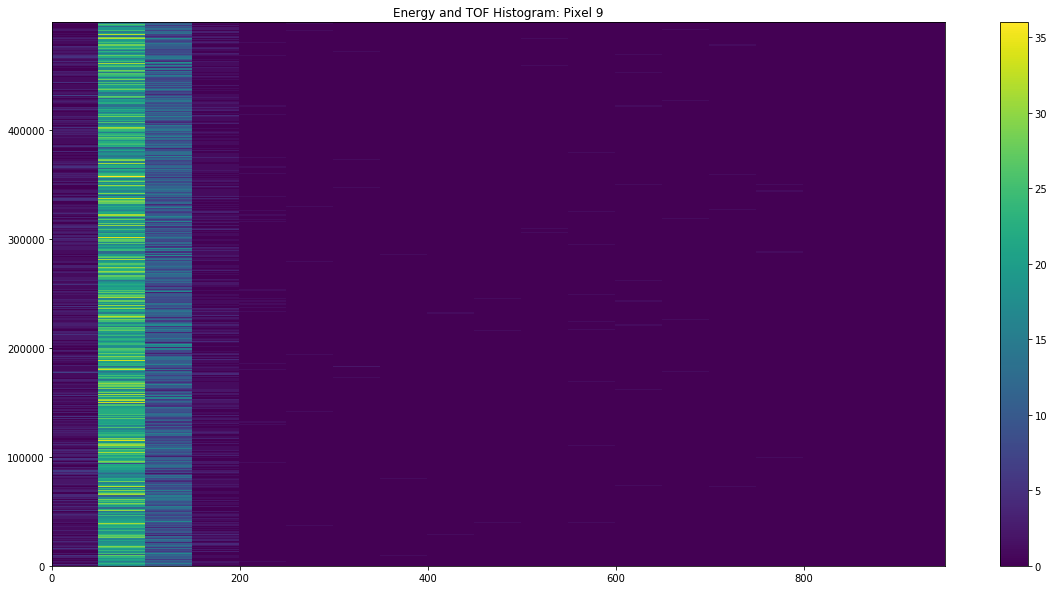

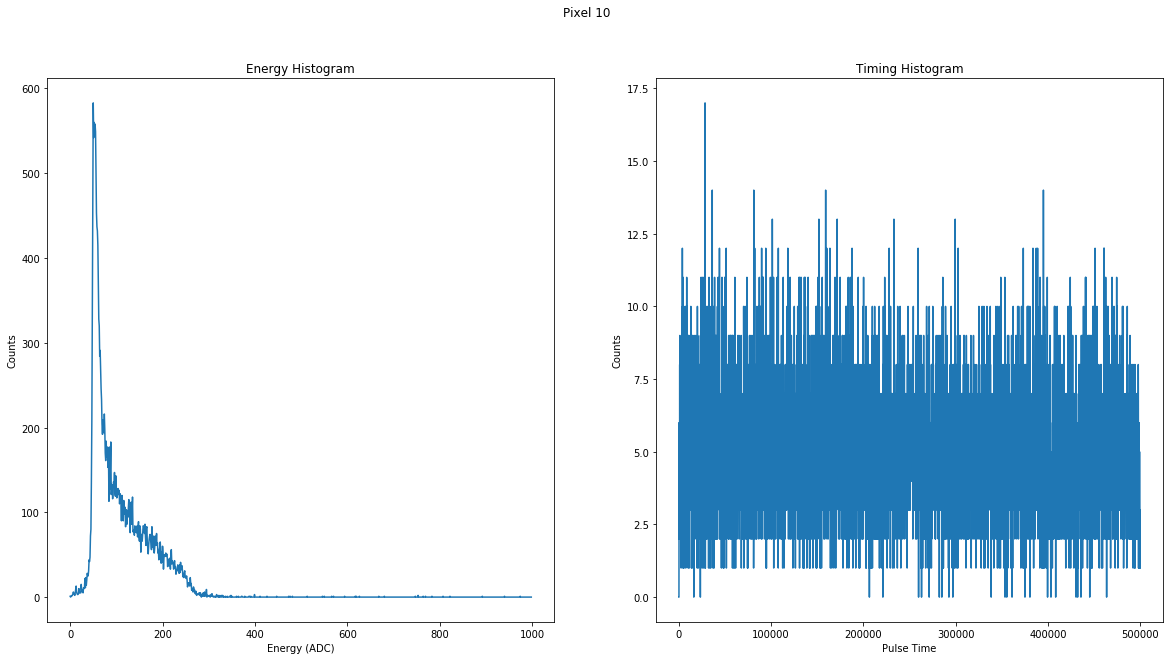

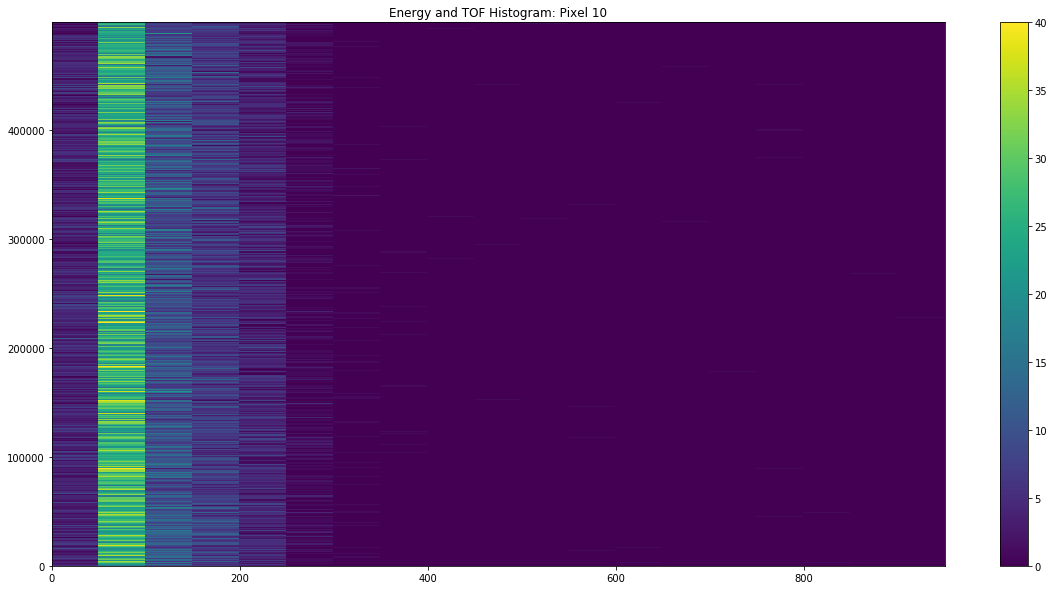

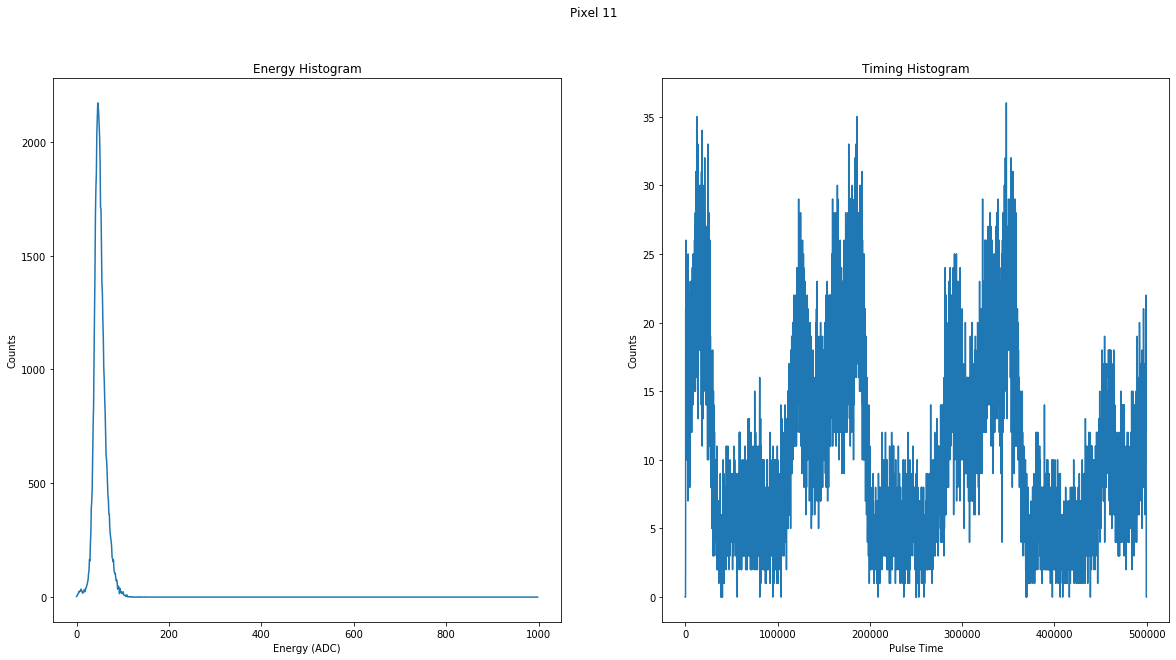

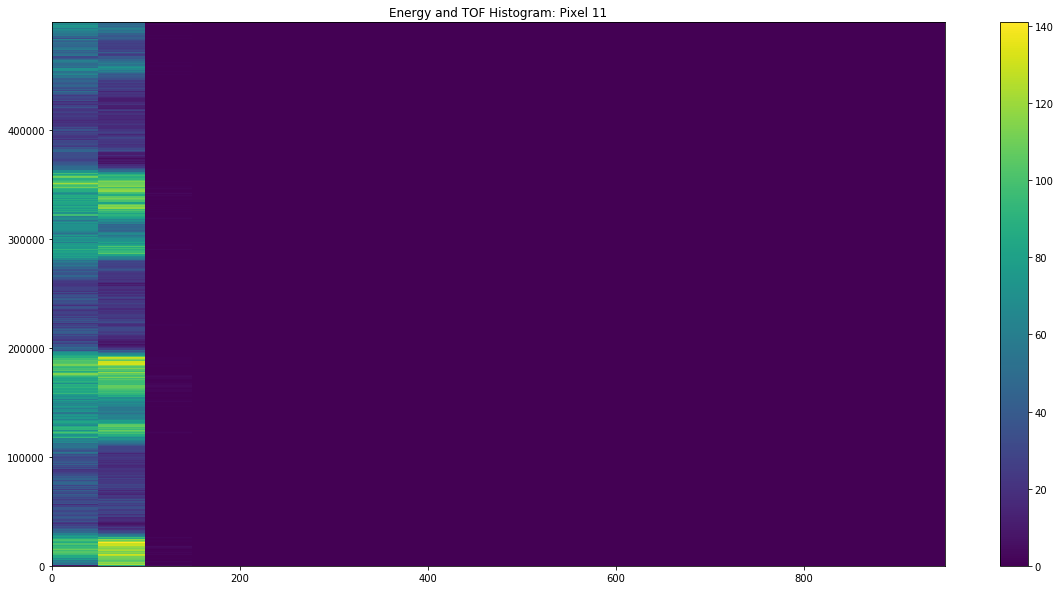

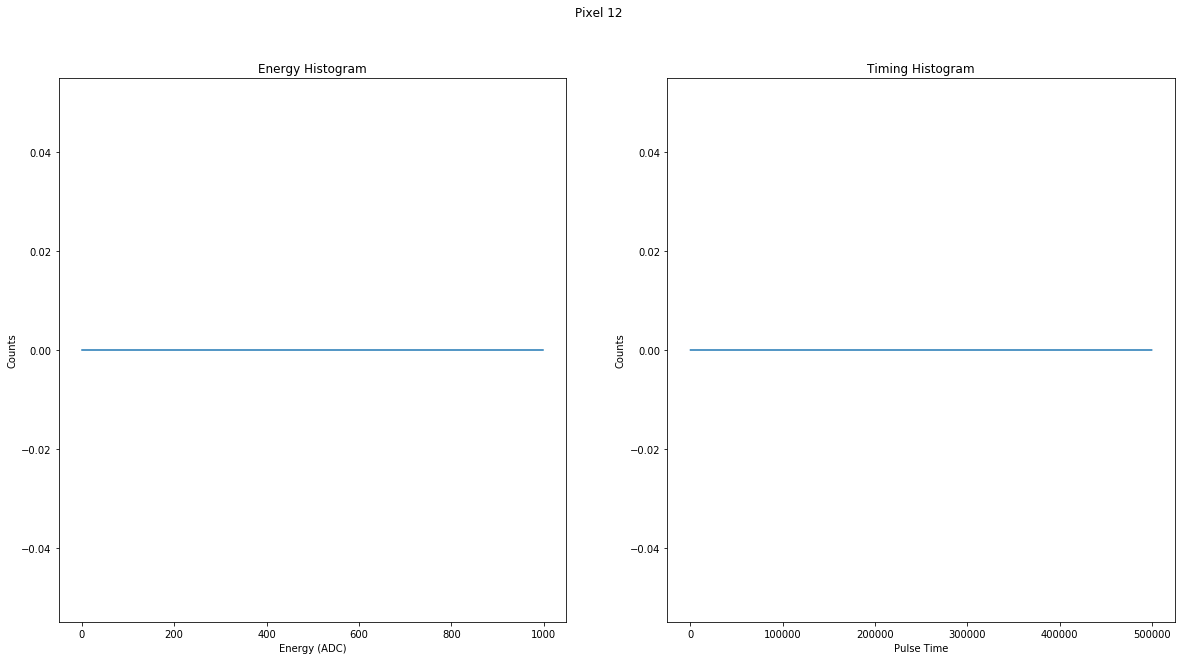

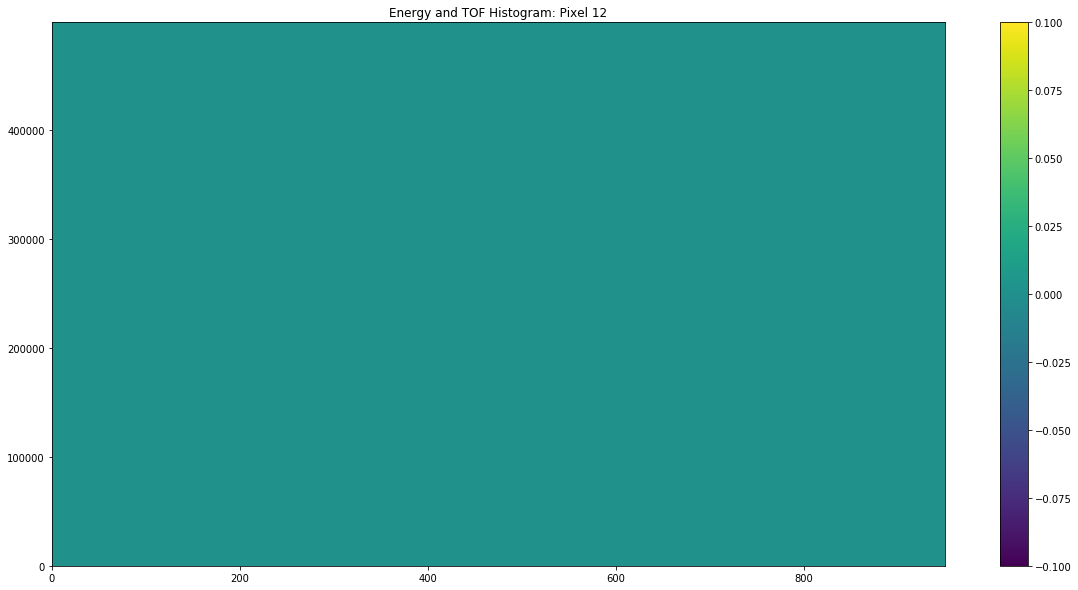

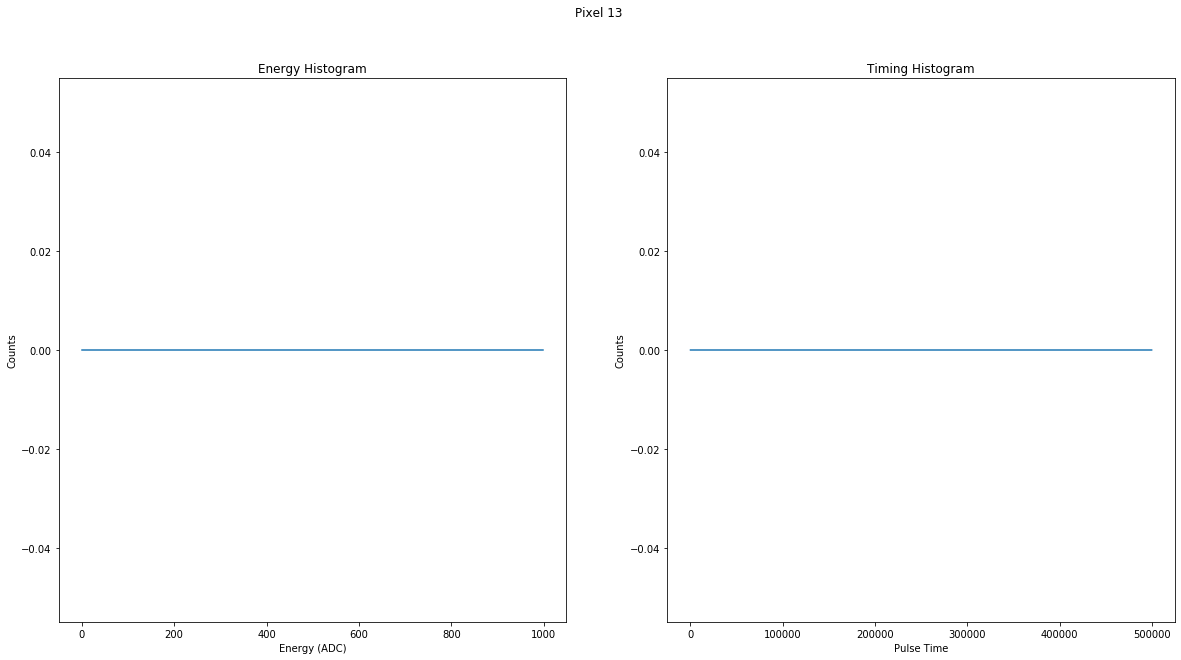

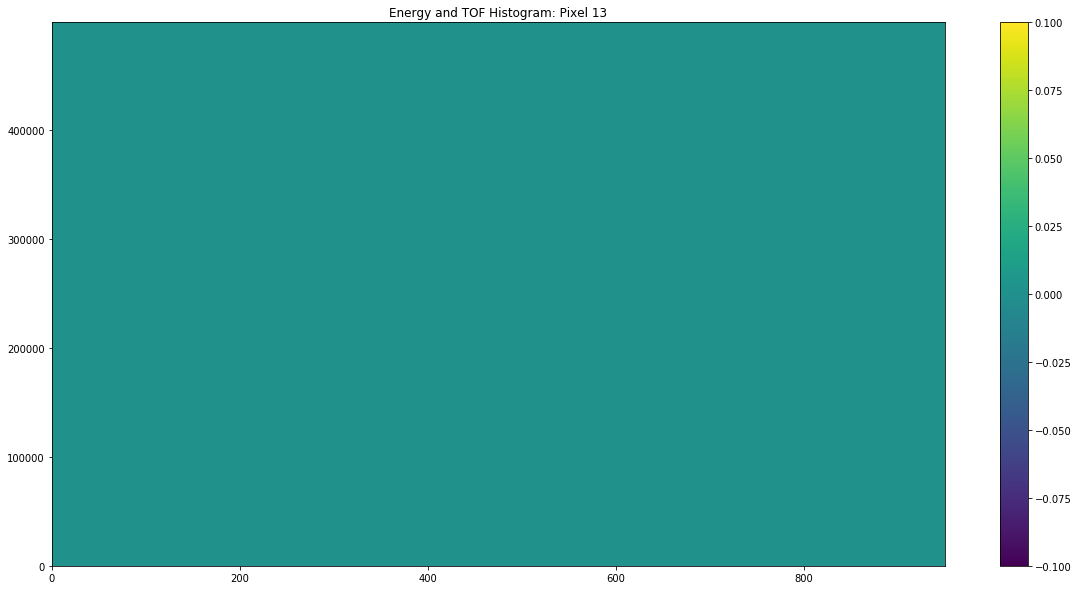

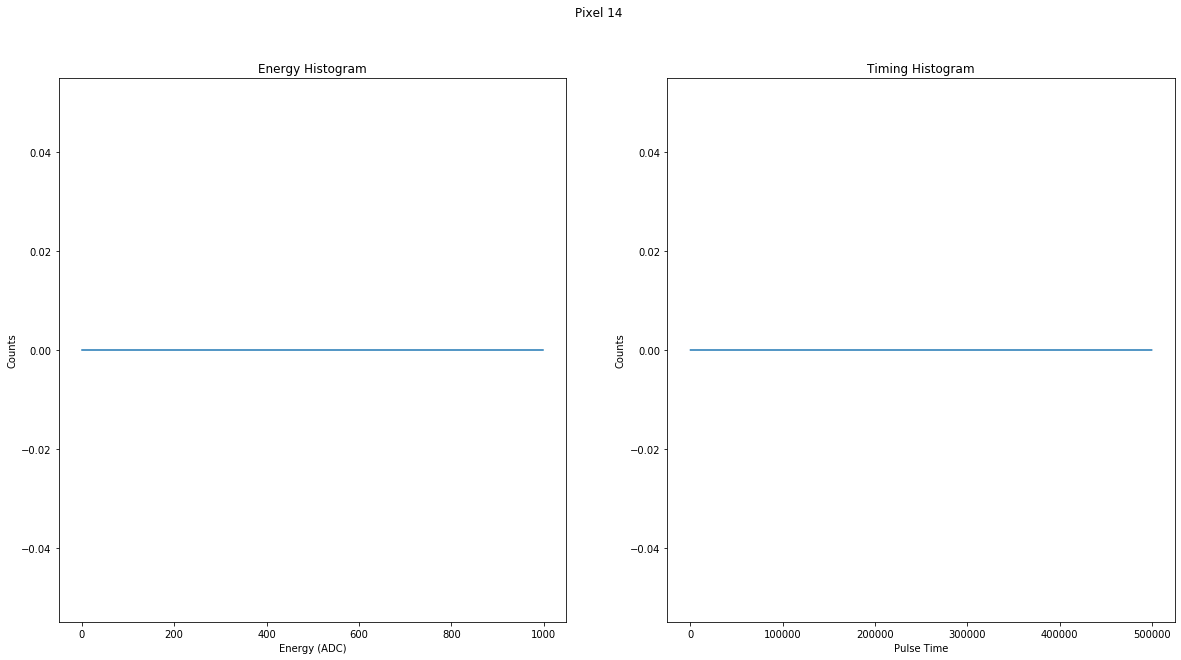

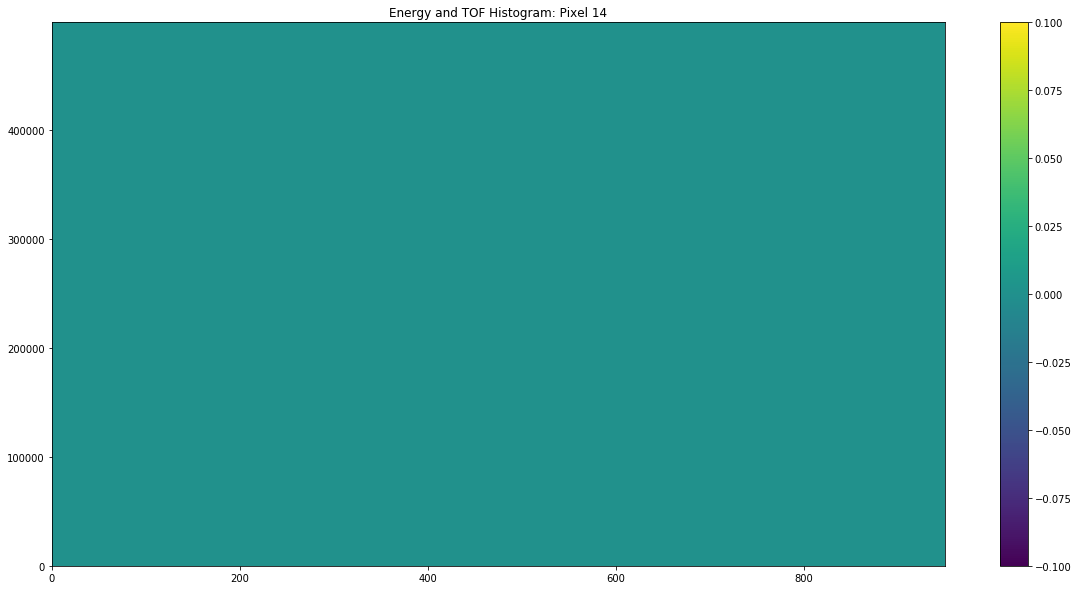

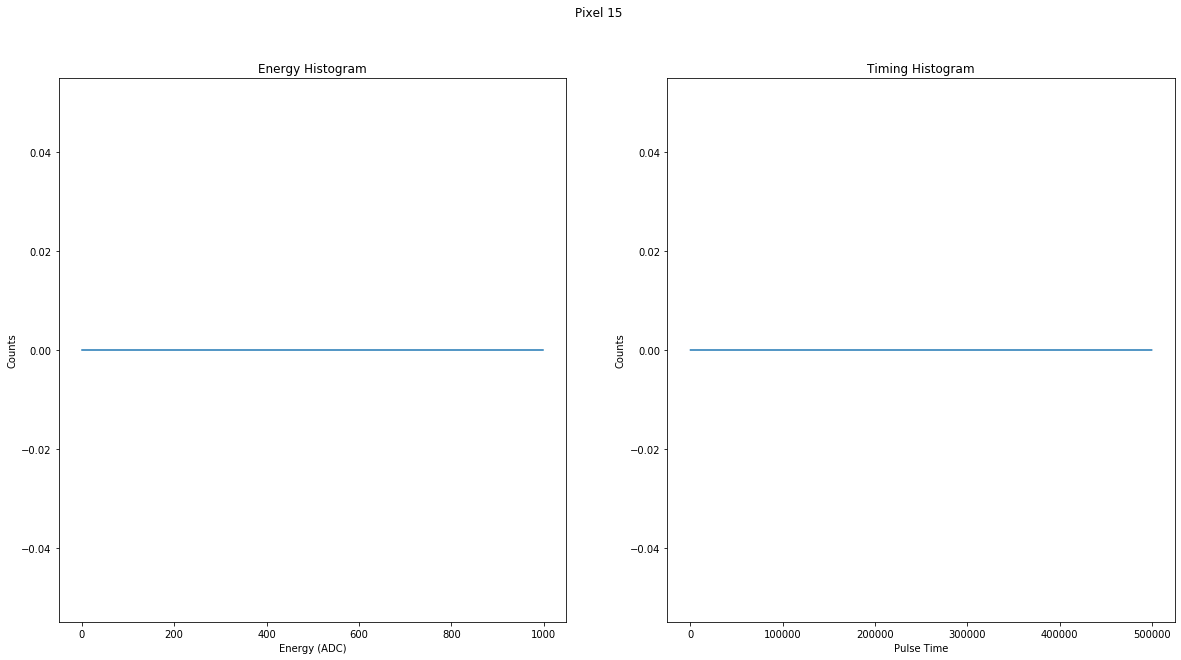

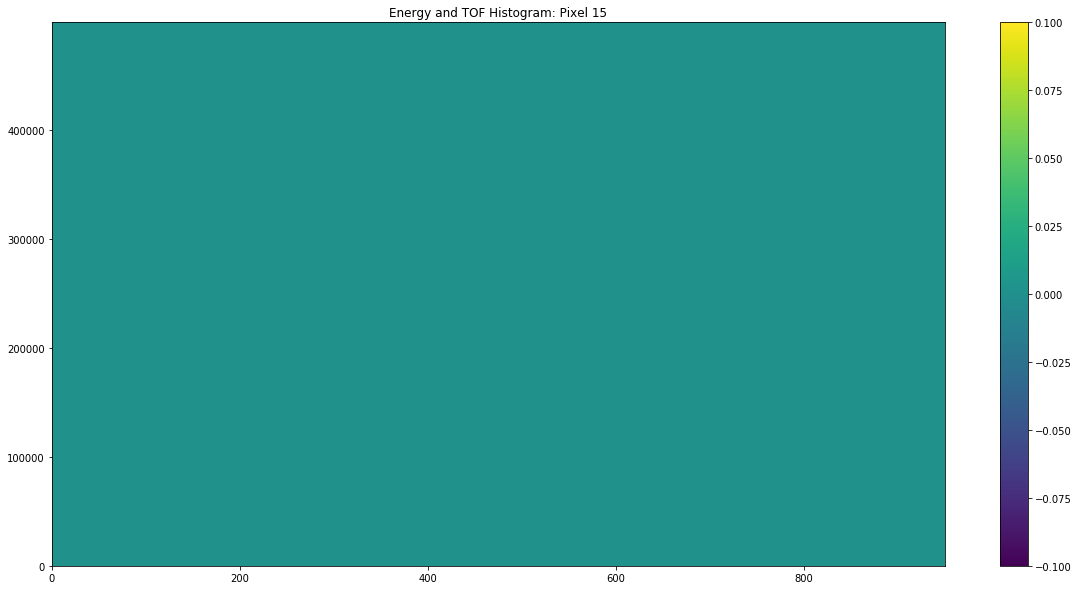

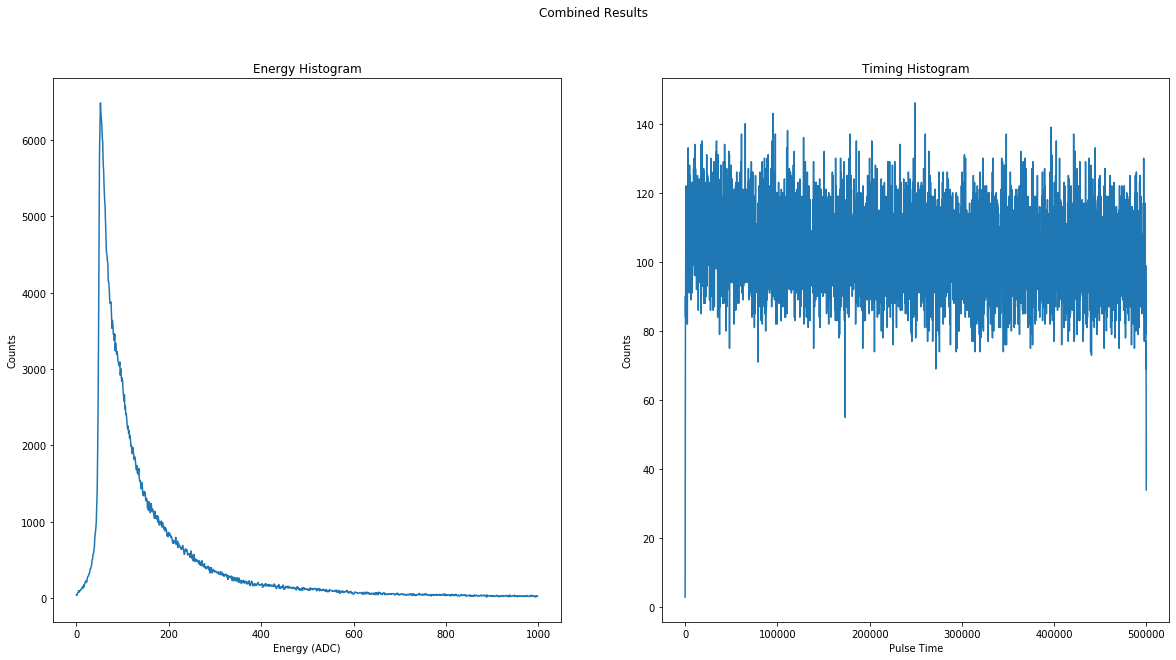

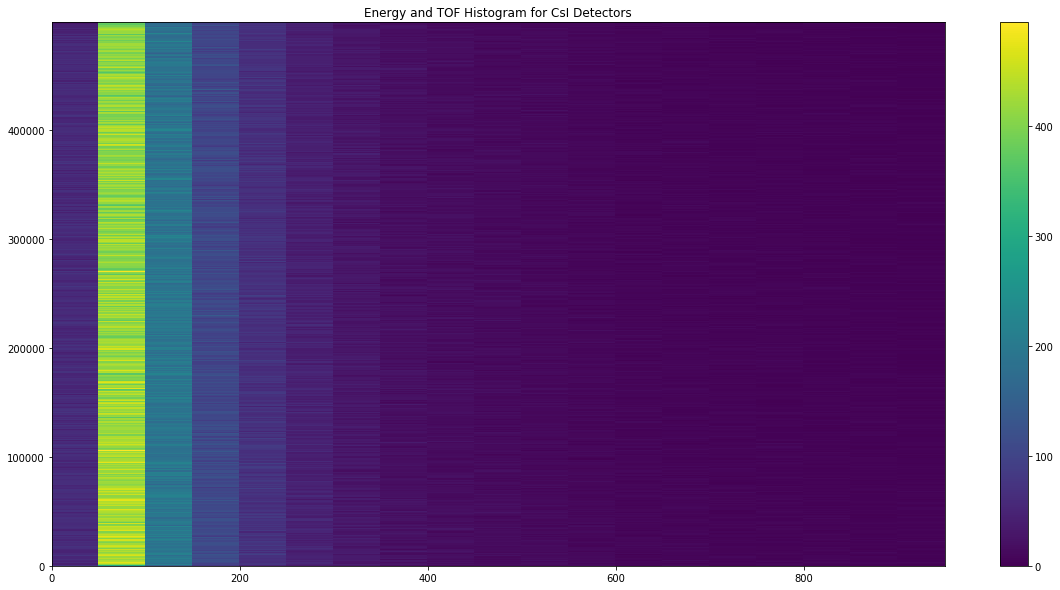

In [9]:
energyHists = []
t0Hists = []
rcParams['figure.figsize'] = 20, 10
for p in range(len(pixelList)):
    #grab all of the results for each pixel
    pixelRes = energyTimingResults[p]
    energies = []
    t0s = []
    for wave in pixelRes[300:]: #now iterate over the waveforms, only after the first batch of 30 files though
        for peak in wave:
            t0s.append(peak[0])
            energies.append(peak[1])
    energyHist = np.histogram(energies, bins = np.arange(0,1000,1))
    timingHist = np.histogram(t0s, bins = np.arange(0,500000, 100))
    
    multiHist, xedges, yedges = np.histogram2d(energies, t0s, bins=[np.arange(0,1000,50),np.arange(0,500000,1000)])
    X, Y = np.meshgrid(xedges, yedges)
    
    fig, [ax1, ax2] = plt.subplots(1, 2)
    fig.suptitle('Pixel '+str(pixelList[p]))
    
    ax1.plot(energyHist[1][:-1], energyHist[0])
    ax1.set_title('Energy Histogram')
    ax1.set_xlabel('Energy (ADC)')
    ax1.set_ylabel('Counts')
    
    ax2.plot(timingHist[1][:-1], timingHist[0])
    ax2.set_title('Timing Histogram')
    ax2.set_xlabel('Pulse Time')
    ax2.set_ylabel('Counts')
                  
    fig.savefig('Histograms for Pixel '+str(pixelList[p])+'.png')
    fig.show()
    
    fig, ax = plt.subplots(nrows=1)
    im = ax.pcolormesh(X, Y, np.transpose(multiHist))
    fig.colorbar(im, ax=ax)
    ax.set_title('Energy and TOF Histogram: Pixel '+str(pixelList[p]))
    fig.show()
    

plist = [0,2,3,4,5,6,7,9,10]
overallEnergies = []
overallT0s = []
for p in plist:
    #grab all of the results for each pixel
    pixelRes = energyTimingResults[p]
    energies = []
    t0s = []
    for wave in pixelRes[300:]:
        for peak in wave:
                t0s.append(peak[0])
                energies.append(peak[1])
    overallEnergies.extend(energies)
    overallT0s.extend(t0s)
    
energyHist = np.histogram(overallEnergies, bins = np.arange(0,1000,1))
timingHist = np.histogram(overallT0s, bins = np.arange(0,500000, 100))
    
multiHist, xedges, yedges = np.histogram2d(overallEnergies, overallT0s, bins=[np.arange(0,1000,50),np.arange(0,500000,1000)])
X, Y = np.meshgrid(xedges, yedges)

fig, [ax1, ax2] = plt.subplots(1, 2)
fig.suptitle('Combined Results')

ax1.plot(energyHist[1][:-1], energyHist[0])
ax1.set_title('Energy Histogram')
ax1.set_xlabel('Energy (ADC)')
ax1.set_ylabel('Counts')

ax2.plot(timingHist[1][:-1], timingHist[0])
ax2.set_title('Timing Histogram')
ax2.set_xlabel('Pulse Time')
ax2.set_ylabel('Counts')
fig.savefig('Combined Histograms.png')
fig.show()

fig, ax = plt.subplots(nrows=1)
im = ax.pcolormesh(X, Y, np.transpose(multiHist))
fig.colorbar(im, ax=ax)
ax.set_title('Energy and TOF Histogram for CsI Detectors')
fig.savefig('2dHistogramEnergyTOFCsIDetectors.png')
fig.show()

